# Autoencoder Lines

Let's use an autoencoder for the Lines dataset. 

The first experiment imports the 2D data points and casts them into a 1D vector. The (x,y) coordinates are mapped into successive inputs. They are hence correlated... This apparently is tremendously difficult to reconstruct for the autoencoder. Why? In the end it is just a difference between input and output. 

In [1]:
from keras.datasets import mnist
import numpy as np
import h5py
#from matplotlib.mlab import griddata
from scipy.interpolate import griddata

filename = '/home/anne/data/h5/lines.h5'
f = h5py.File(filename, 'r')
#for key in f.keys():
#    print(key)
data = np.array(f["data"])

def pnts2grid(x, y, resX=28, resY=28):
    xrange = np.linspace(0, resX - 1, 1)
    yrange = np.linspace(0, resY - 1, 1)
    Z = np.zeros((resX, resY))
    for i in range(len(x)):
        xpixel = round((x[i] - min(x)) / (max(x) - min(x)) * resX - 1).astype('int')
        ypixel = round((y[i] - min(y)) / (max(y) - min(y)) * resY - 1).astype('int')
        Z[xpixel,ypixel] = 1
    return Z

# Training and test set are 2D points
N = 100
resX = resY = 28
z = np.zeros((N, resX, resY))
for i in range(N):
    x = data[i,:,0]
    y = data[i,:,1]
    z[i,:,:] = pnts2grid(x, y, resX, resY)

x_train = z[0:80]
x_test  = z[80:N]

# Print one particular input to check if the discretization to a 28x28 grid went okay
zfig=x_train[1]
import matplotlib.pyplot as plt
plt.imshow(zfig, interpolation='nearest', cmap='Blues',
    extent=(0.5,np.shape(zfig)[0]+0.5,0.5,np.shape(zfig)[1]+0.5))
plt.colorbar()
plt.show()
    
# Make them into 32-bit floats
#x_train = x_train.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 

# Create 1-dimensional vector of input, the coordinates are just fed into subsequent input nodes
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

input_size = x_train.shape[1]

Using TensorFlow backend.


<Figure size 640x480 with 2 Axes>

(80, 784)
(20, 784)


In [2]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations (was 32)
encoding_dim = 10
batch_size = 100
epochs = 1000

# this is our input placeholder
input_img = Input(shape=(input_size,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_size, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               8624      
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [4]:
# types of optimizers:
#  adam
#  adagrad
#  sgd
# types of losses:
# - mean_absolute_error (gets all zeros)
# - hinge, squared_hinge
# - logcosh
# - kullback_leibler_divergence (gest all ones)
# - binary_crossentropy (adam/adagrad gets somewhere)
# - poisson (as well)
# - cosine_proximity (vague)
autoencoder.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

In [5]:
# the autoencoder should learn to map the x_train input data to x_train as output
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=False,
                validation_data=(x_test, x_test))

Train on 80 samples, validate on 20 samples
Epoch 1/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.1567 - val_loss: 0.1566
Epoch 2/1000
80/80 [==============================] - 0s 78us/step - loss: 0.1564 - val_loss: 0.1563
Epoch 3/1000
80/80 [==============================] - 0s 66us/step - loss: 0.1561 - val_loss: 0.1560
Epoch 4/1000
80/80 [==============================] - 0s 65us/step - loss: 0.1557 - val_loss: 0.1556
Epoch 5/1000
80/80 [==============================] - 0s 60us/step - loss: 0.1553 - val_loss: 0.1552
Epoch 6/1000
80/80 [==============================] - 0s 73us/step - loss: 0.1548 - val_loss: 0.1546
Epoch 7/1000
80/80 [==============================] - 0s 62us/step - loss: 0.1542 - val_loss: 0.1540
Epoch 8/1000
80/80 [==============================] - 0s 54us/step - loss: 0.1536 - val_loss: 0.1533
Epoch 9/1000
80/80 [==============================] - 0s 116us/step - loss: 0.1528 - val_loss: 0.1525
Epoch 10/1000
80/80 [==========================

Epoch 81/1000
80/80 [==============================] - 0s 64us/step - loss: 0.0414 - val_loss: 0.0422
Epoch 82/1000
80/80 [==============================] - 0s 81us/step - loss: 0.0413 - val_loss: 0.0422
Epoch 83/1000
80/80 [==============================] - 0s 53us/step - loss: 0.0413 - val_loss: 0.0422
Epoch 84/1000
80/80 [==============================] - 0s 63us/step - loss: 0.0413 - val_loss: 0.0422
Epoch 85/1000
80/80 [==============================] - 0s 67us/step - loss: 0.0413 - val_loss: 0.0422
Epoch 86/1000
80/80 [==============================] - 0s 60us/step - loss: 0.0412 - val_loss: 0.0421
Epoch 87/1000
80/80 [==============================] - 0s 81us/step - loss: 0.0412 - val_loss: 0.0421
Epoch 88/1000
80/80 [==============================] - 0s 57us/step - loss: 0.0412 - val_loss: 0.0421
Epoch 89/1000
80/80 [==============================] - 0s 89us/step - loss: 0.0411 - val_loss: 0.0421
Epoch 90/1000
80/80 [==============================] - 0s 74us/step - loss: 0.0411

Epoch 161/1000
80/80 [==============================] - 0s 79us/step - loss: 0.0403 - val_loss: 0.0419
Epoch 162/1000
80/80 [==============================] - 0s 76us/step - loss: 0.0403 - val_loss: 0.0419
Epoch 163/1000
80/80 [==============================] - 0s 80us/step - loss: 0.0403 - val_loss: 0.0419
Epoch 164/1000
80/80 [==============================] - 0s 75us/step - loss: 0.0403 - val_loss: 0.0419
Epoch 165/1000
80/80 [==============================] - 0s 160us/step - loss: 0.0402 - val_loss: 0.0419
Epoch 166/1000
80/80 [==============================] - 0s 131us/step - loss: 0.0402 - val_loss: 0.0419
Epoch 167/1000
80/80 [==============================] - 0s 107us/step - loss: 0.0402 - val_loss: 0.0419
Epoch 168/1000
80/80 [==============================] - 0s 99us/step - loss: 0.0402 - val_loss: 0.0419
Epoch 169/1000
80/80 [==============================] - 0s 81us/step - loss: 0.0402 - val_loss: 0.0419
Epoch 170/1000
80/80 [==============================] - 0s 121us/step 

Epoch 241/1000
80/80 [==============================] - 0s 70us/step - loss: 0.0397 - val_loss: 0.0419
Epoch 242/1000
80/80 [==============================] - 0s 94us/step - loss: 0.0397 - val_loss: 0.0419
Epoch 243/1000
80/80 [==============================] - 0s 92us/step - loss: 0.0397 - val_loss: 0.0419
Epoch 244/1000
80/80 [==============================] - 0s 174us/step - loss: 0.0397 - val_loss: 0.0419
Epoch 245/1000
80/80 [==============================] - 0s 120us/step - loss: 0.0397 - val_loss: 0.0419
Epoch 246/1000
80/80 [==============================] - 0s 66us/step - loss: 0.0397 - val_loss: 0.0419
Epoch 247/1000
80/80 [==============================] - 0s 192us/step - loss: 0.0397 - val_loss: 0.0419
Epoch 248/1000
80/80 [==============================] - 0s 141us/step - loss: 0.0397 - val_loss: 0.0419
Epoch 249/1000
80/80 [==============================] - 0s 78us/step - loss: 0.0397 - val_loss: 0.0419
Epoch 250/1000
80/80 [==============================] - 0s 147us/step

Epoch 321/1000
80/80 [==============================] - 0s 53us/step - loss: 0.0392 - val_loss: 0.0419
Epoch 322/1000
80/80 [==============================] - 0s 51us/step - loss: 0.0392 - val_loss: 0.0419
Epoch 323/1000
80/80 [==============================] - 0s 52us/step - loss: 0.0391 - val_loss: 0.0419
Epoch 324/1000
80/80 [==============================] - 0s 56us/step - loss: 0.0391 - val_loss: 0.0419
Epoch 325/1000
80/80 [==============================] - 0s 52us/step - loss: 0.0391 - val_loss: 0.0419
Epoch 326/1000
80/80 [==============================] - 0s 49us/step - loss: 0.0391 - val_loss: 0.0419
Epoch 327/1000
80/80 [==============================] - 0s 55us/step - loss: 0.0391 - val_loss: 0.0419
Epoch 328/1000
80/80 [==============================] - 0s 88us/step - loss: 0.0391 - val_loss: 0.0419
Epoch 329/1000
80/80 [==============================] - 0s 55us/step - loss: 0.0391 - val_loss: 0.0419
Epoch 330/1000
80/80 [==============================] - 0s 56us/step - lo

Epoch 401/1000
80/80 [==============================] - 0s 67us/step - loss: 0.0383 - val_loss: 0.0419
Epoch 402/1000
80/80 [==============================] - 0s 67us/step - loss: 0.0383 - val_loss: 0.0419
Epoch 403/1000
80/80 [==============================] - 0s 59us/step - loss: 0.0383 - val_loss: 0.0419
Epoch 404/1000
80/80 [==============================] - 0s 64us/step - loss: 0.0383 - val_loss: 0.0419
Epoch 405/1000
80/80 [==============================] - 0s 193us/step - loss: 0.0383 - val_loss: 0.0419
Epoch 406/1000
80/80 [==============================] - 0s 63us/step - loss: 0.0382 - val_loss: 0.0419
Epoch 407/1000
80/80 [==============================] - 0s 68us/step - loss: 0.0382 - val_loss: 0.0419
Epoch 408/1000
80/80 [==============================] - 0s 70us/step - loss: 0.0382 - val_loss: 0.0419
Epoch 409/1000
80/80 [==============================] - 0s 61us/step - loss: 0.0382 - val_loss: 0.0419
Epoch 410/1000
80/80 [==============================] - 0s 67us/step - l

Epoch 481/1000
80/80 [==============================] - 0s 52us/step - loss: 0.0370 - val_loss: 0.0419
Epoch 482/1000
80/80 [==============================] - 0s 53us/step - loss: 0.0370 - val_loss: 0.0418
Epoch 483/1000
80/80 [==============================] - 0s 55us/step - loss: 0.0370 - val_loss: 0.0418
Epoch 484/1000
80/80 [==============================] - 0s 50us/step - loss: 0.0370 - val_loss: 0.0418
Epoch 485/1000
80/80 [==============================] - 0s 71us/step - loss: 0.0370 - val_loss: 0.0418
Epoch 486/1000
80/80 [==============================] - 0s 72us/step - loss: 0.0369 - val_loss: 0.0418
Epoch 487/1000
80/80 [==============================] - 0s 51us/step - loss: 0.0369 - val_loss: 0.0418
Epoch 488/1000
80/80 [==============================] - 0s 52us/step - loss: 0.0369 - val_loss: 0.0418
Epoch 489/1000
80/80 [==============================] - 0s 54us/step - loss: 0.0369 - val_loss: 0.0418
Epoch 490/1000
80/80 [==============================] - 0s 60us/step - lo

Epoch 561/1000
80/80 [==============================] - 0s 55us/step - loss: 0.0354 - val_loss: 0.0416
Epoch 562/1000
80/80 [==============================] - 0s 67us/step - loss: 0.0354 - val_loss: 0.0416
Epoch 563/1000
80/80 [==============================] - 0s 72us/step - loss: 0.0354 - val_loss: 0.0416
Epoch 564/1000
80/80 [==============================] - 0s 111us/step - loss: 0.0353 - val_loss: 0.0415
Epoch 565/1000
80/80 [==============================] - 0s 109us/step - loss: 0.0353 - val_loss: 0.0415
Epoch 566/1000
80/80 [==============================] - 0s 70us/step - loss: 0.0353 - val_loss: 0.0415
Epoch 567/1000
80/80 [==============================] - 0s 54us/step - loss: 0.0353 - val_loss: 0.0415
Epoch 568/1000
80/80 [==============================] - 0s 52us/step - loss: 0.0353 - val_loss: 0.0415
Epoch 569/1000
80/80 [==============================] - 0s 63us/step - loss: 0.0352 - val_loss: 0.0415
Epoch 570/1000
80/80 [==============================] - 0s 48us/step - 

Epoch 641/1000
80/80 [==============================] - 0s 63us/step - loss: 0.0336 - val_loss: 0.0412
Epoch 642/1000
80/80 [==============================] - 0s 118us/step - loss: 0.0336 - val_loss: 0.0412
Epoch 643/1000
80/80 [==============================] - 0s 56us/step - loss: 0.0335 - val_loss: 0.0412
Epoch 644/1000
80/80 [==============================] - 0s 84us/step - loss: 0.0335 - val_loss: 0.0412
Epoch 645/1000
80/80 [==============================] - 0s 129us/step - loss: 0.0335 - val_loss: 0.0412
Epoch 646/1000
80/80 [==============================] - 0s 92us/step - loss: 0.0335 - val_loss: 0.0412
Epoch 647/1000
80/80 [==============================] - 0s 59us/step - loss: 0.0335 - val_loss: 0.0412
Epoch 648/1000
80/80 [==============================] - 0s 65us/step - loss: 0.0334 - val_loss: 0.0412
Epoch 649/1000
80/80 [==============================] - 0s 56us/step - loss: 0.0334 - val_loss: 0.0412
Epoch 650/1000
80/80 [==============================] - 0s 69us/step - 

Epoch 721/1000
80/80 [==============================] - 0s 62us/step - loss: 0.0317 - val_loss: 0.0409
Epoch 722/1000
80/80 [==============================] - 0s 66us/step - loss: 0.0317 - val_loss: 0.0409
Epoch 723/1000
80/80 [==============================] - 0s 54us/step - loss: 0.0317 - val_loss: 0.0409
Epoch 724/1000
80/80 [==============================] - 0s 55us/step - loss: 0.0316 - val_loss: 0.0409
Epoch 725/1000
80/80 [==============================] - 0s 55us/step - loss: 0.0316 - val_loss: 0.0409
Epoch 726/1000
80/80 [==============================] - 0s 57us/step - loss: 0.0316 - val_loss: 0.0409
Epoch 727/1000
80/80 [==============================] - 0s 53us/step - loss: 0.0316 - val_loss: 0.0409
Epoch 728/1000
80/80 [==============================] - 0s 48us/step - loss: 0.0315 - val_loss: 0.0409
Epoch 729/1000
80/80 [==============================] - 0s 95us/step - loss: 0.0315 - val_loss: 0.0409
Epoch 730/1000
80/80 [==============================] - 0s 62us/step - lo

Epoch 801/1000
80/80 [==============================] - 0s 56us/step - loss: 0.0299 - val_loss: 0.0407
Epoch 802/1000
80/80 [==============================] - 0s 63us/step - loss: 0.0299 - val_loss: 0.0407
Epoch 803/1000
80/80 [==============================] - 0s 62us/step - loss: 0.0298 - val_loss: 0.0407
Epoch 804/1000
80/80 [==============================] - 0s 67us/step - loss: 0.0298 - val_loss: 0.0407
Epoch 805/1000
80/80 [==============================] - 0s 67us/step - loss: 0.0298 - val_loss: 0.0407
Epoch 806/1000
80/80 [==============================] - 0s 64us/step - loss: 0.0298 - val_loss: 0.0407
Epoch 807/1000
80/80 [==============================] - 0s 71us/step - loss: 0.0297 - val_loss: 0.0407
Epoch 808/1000
80/80 [==============================] - 0s 73us/step - loss: 0.0297 - val_loss: 0.0407
Epoch 809/1000
80/80 [==============================] - 0s 53us/step - loss: 0.0297 - val_loss: 0.0407
Epoch 810/1000
80/80 [==============================] - 0s 54us/step - lo

Epoch 881/1000
80/80 [==============================] - 0s 69us/step - loss: 0.0282 - val_loss: 0.0406
Epoch 882/1000
80/80 [==============================] - 0s 56us/step - loss: 0.0282 - val_loss: 0.0406
Epoch 883/1000
80/80 [==============================] - 0s 59us/step - loss: 0.0282 - val_loss: 0.0406
Epoch 884/1000
80/80 [==============================] - 0s 55us/step - loss: 0.0281 - val_loss: 0.0406
Epoch 885/1000
80/80 [==============================] - 0s 52us/step - loss: 0.0281 - val_loss: 0.0406
Epoch 886/1000
80/80 [==============================] - 0s 55us/step - loss: 0.0281 - val_loss: 0.0406
Epoch 887/1000
80/80 [==============================] - 0s 58us/step - loss: 0.0281 - val_loss: 0.0406
Epoch 888/1000
80/80 [==============================] - 0s 52us/step - loss: 0.0281 - val_loss: 0.0406
Epoch 889/1000
80/80 [==============================] - 0s 64us/step - loss: 0.0280 - val_loss: 0.0406
Epoch 890/1000
80/80 [==============================] - 0s 76us/step - lo

Epoch 961/1000
80/80 [==============================] - 0s 71us/step - loss: 0.0267 - val_loss: 0.0405
Epoch 962/1000
80/80 [==============================] - 0s 58us/step - loss: 0.0267 - val_loss: 0.0405
Epoch 963/1000
80/80 [==============================] - 0s 53us/step - loss: 0.0267 - val_loss: 0.0405
Epoch 964/1000
80/80 [==============================] - 0s 69us/step - loss: 0.0267 - val_loss: 0.0405
Epoch 965/1000
80/80 [==============================] - 0s 69us/step - loss: 0.0266 - val_loss: 0.0405
Epoch 966/1000
80/80 [==============================] - 0s 73us/step - loss: 0.0266 - val_loss: 0.0405
Epoch 967/1000
80/80 [==============================] - 0s 63us/step - loss: 0.0266 - val_loss: 0.0405
Epoch 968/1000
80/80 [==============================] - 0s 63us/step - loss: 0.0266 - val_loss: 0.0405
Epoch 969/1000
80/80 [==============================] - 0s 56us/step - loss: 0.0266 - val_loss: 0.0405
Epoch 970/1000
80/80 [==============================] - 0s 64us/step - lo

In [6]:
# encode and decode lines
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

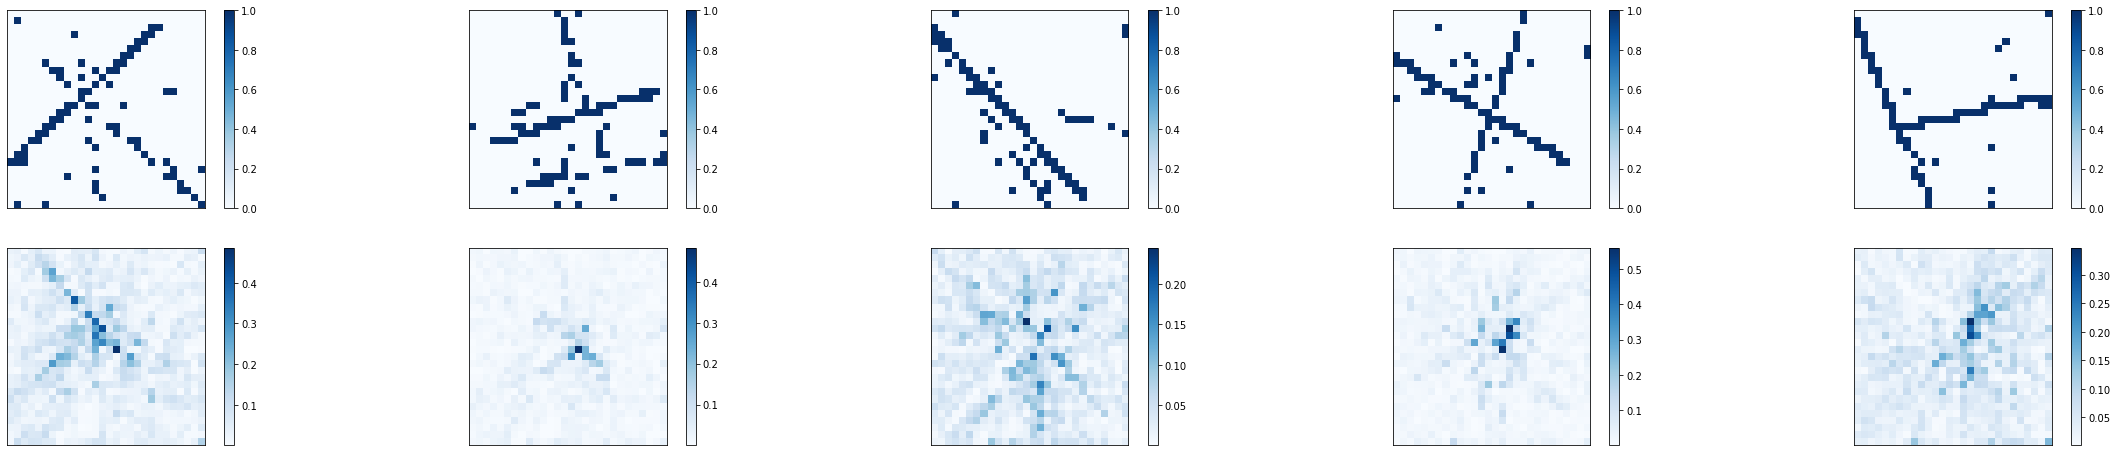

In [7]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 5  # how many digits we will display
plt.figure(figsize=(40, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #original = x_test[i].reshape(round(input_size/2), 2)
    #plt.scatter(original[:, 0], original[:, 1], cmap='Blues')
    original = x_test[i].reshape((resX, resY))
    plt.imshow(original, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(original)[0]+0.5,0.5,np.shape(original)[1]+0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    #reconstruction = decoded_imgs[i].reshape(round(input_size/2), 2)
    #plt.scatter(reconstruction[:, 0], reconstruction[:, 1], cmap='Blues')
    reconstruction = decoded_imgs[i].reshape((resX, resY))
    plt.imshow(reconstruction, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(reconstruction)[0]+0.5,0.5,np.shape(reconstruction)[1]+0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.colorbar()
plt.show()

In [8]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

with plt.style.context(['default','ggplot'], after_reset=True):
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='Blues')
    plt.colorbar()
    plt.show()

NameError: name 'y_test' is not defined

<Figure size 600x600 with 0 Axes>

In [ ]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

#z_mu_base = np.random.rand(1, encoding_dim);

z_select = np.arange(encoding_dim)
np.random.shuffle(z_select)

z_mu_all = encoder.predict(x_test)
z_mu_base0 = np.reshape(z_mu_all[z_select[0]], (1, encoding_dim))
z_mu_base1 = np.reshape(z_mu_all[z_select[1]], (1, encoding_dim))
z_mu_base2 = np.reshape(z_mu_all[z_select[2]], (1, encoding_dim))
z_mu_base3 = np.reshape(z_mu_all[z_select[3]], (1, encoding_dim))

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        #z_mu = np.array([[xi, yi]]) # only for 2 dim
        # Show interpolations between four randomly chosen digits from the test set 
        z_mu = z_mu_base0 * ((xi + 3)/6)*(1-(yi + 3)/6) + z_mu_base1 * (1-(xi + 3)/6)*((yi + 3)/6)
        z_mu += z_mu_base2 * ((xi + 3)/6)*((yi + 3)/6) + z_mu_base3 * (1-(xi + 3)/6)*(1-(yi + 3)/6)
        x_mean = decoder.predict(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

In [ ]:
# The density of the layer with latent variables (not sparse!)
encoded_imgs.mean()